# Regularization

Regularization is an important technique used to prevent overfitting in machine learning models. This notebook shows different regularization approaches to reduce overfitting.

We use a modification and curated version of the [Housing Prices Dataset](https://www.kaggle.com/datasets/yasserh/housing-prices-dataset) stored in `data/housing_curated.csv`.

In [17]:
# make sure the required packages are installed
%pip install numpy pandas scikit-learn matplotlib seaborn --quiet

from sklearn.linear_model import SGDRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
import pandas as pd

import utils

pd.set_option('display.max_columns', None)  # Display all columns of a DataFrame in pandas
random_state = 42

Note: you may need to restart the kernel to use updated packages.


## Dataset

Dataset meta information:

In [18]:
dataset_file_name = 'data/housing_curated.csv'
integer_independent_vars = ['bedrooms', 'bathrooms', 'stories', 'parking', 'width', 'length', 'quality']
binary_independent_vars = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea',
            'furnishingstatus_furnished','furnishingstatus_semi-furnished','furnishingstatus_unfurnished']
independent_vars = integer_independent_vars + binary_independent_vars
dependent_var = 'price'

### Load the dataset

Load the dataset and break it into training and testing sets.

In [19]:
# Split the dataset into training and testing sets
(X_train, y_train), (X_test, y_test) = utils.load_dataset_from_csv(dataset_file_name, independent_vars,
                                                                   dependent_var, 0.2, random_state)
print(f"Training set shape: {X_train.shape}.")
print("Training set description:\n", X_train.describe(), end='\n\n')

Training set shape: (439, 16).
Training set description:
          bedrooms   bathrooms     stories     parking       width      length  \
count  439.000000  439.000000  439.000000  439.000000  439.000000  439.000000   
mean     2.979499    1.289294    1.840547    0.678815   49.339408  119.840547   
std      0.732194    0.506261    0.882139    0.849003   12.407137   25.782938   
min      1.000000    1.000000    1.000000    0.000000   26.000000   70.000000   
25%      3.000000    1.000000    1.000000    0.000000   41.500000  102.000000   
50%      3.000000    1.000000    2.000000    0.000000   48.000000  117.000000   
75%      3.000000    2.000000    2.000000    1.000000   55.500000  136.000000   
max      6.000000    4.000000    4.000000    3.000000  183.000000  310.000000   

           quality    mainroad   guestroom    basement  hotwaterheating  \
count   439.000000  439.000000  439.000000  439.000000       439.000000   
mean   2165.685649    0.854214    0.182232    0.350797        

### Scale the dataset

Scale the dataset using the `RobustScaler` which is more robust to outliers.

In [20]:
# Scale the dataset
X_train_scaled, X_test_scaled = utils.scale_X_dataset(RobustScaler(), X_train, X_test)
# show the number of features
print(f"Training set shape: {X_train_scaled.shape}.")

Training set shape: (439, 16).


## Linear Regression Model

Train a linear regression model on the dataset and evaluate its performance.

Model performance with the original features:


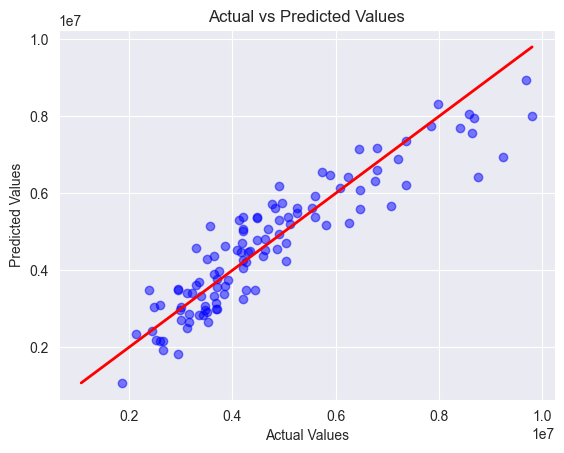

Mean Squared Error (MSE): 507668902357.6780
Root Mean Squared Error (RMSE): 712508.8788
Mean Absolute Error (MAE): 560334.4883
R-squared determination coefficient: 0.8396


In [21]:
print("Model performance with the original features:")
utils.show_regression_performance(
    *utils.create_SDG_regression_model_and_evaluate(X_train_scaled, y_train, X_test_scaled, y_test, random_state))

## Polynomial Regression Model

We now create a polynomial regression model, scale the new features, fit it to the dataset, and evaluate its performance.

Training set shape: (439, 968).
Model performance after adding the polynomial features:


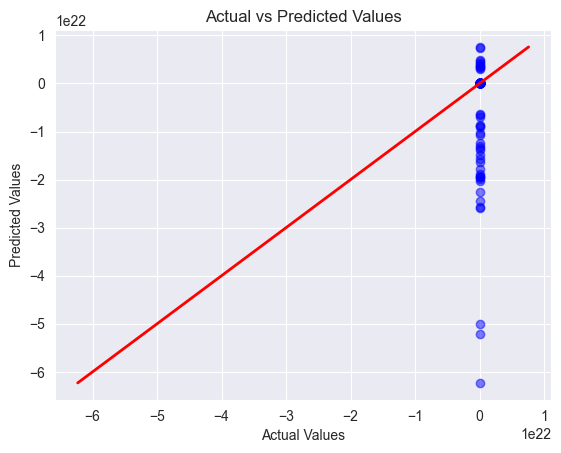

Mean Squared Error (MSE): 149351967041863117170554739049846726094487552.0000
Root Mean Squared Error (RMSE): 12220964243539178291200.0000
Mean Absolute Error (MAE): 5592439240384675053568.0000
R-squared determination coefficient: -47194194509950066241897416884224.0000


In [22]:
# Create the polynomial features with degree of 3
poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)
# show the number of features
print(f"Training set shape: {X_train_poly.shape}.")
# Scale the dataset
X_train_scaled, X_test_scaled = utils.scale_X_dataset(RobustScaler(), X_train_poly, X_test_poly)
# evaluate the model
print("Model performance after adding the polynomial features:")
utils.show_regression_performance(
    *utils.create_SDG_regression_model_and_evaluate(X_train_scaled, y_train, X_test_scaled, y_test, random_state))

## ✨ Questions ✨

1. Does the model's performance improve after adding polynomial features?
2. Why?
3. How can we reduce overfitting?

### Answers

*Write your answers here.*

1. No, it deacreases.
2. The model is overfitting the training data. The are are two many features (and the complexity of the model increases) leading to overfitting.
3. We have different options: lowering complexity, adding more data, feature selection and regularization techniques.

## Feature Selection

Let's select the best features using the `SelectKBest` method and evaluate the model's performance. `SelectKBest` selects the top k features based on a parameterizable score. 

Model performance after adding the polynomial features and selecting the best 16 features:


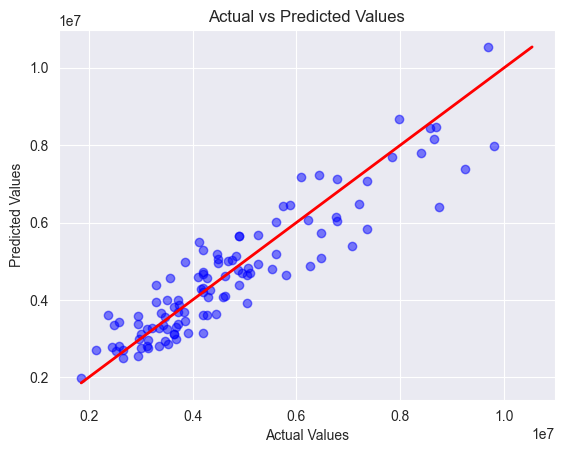

Mean Squared Error (MSE): 492685409256.6889
Root Mean Squared Error (RMSE): 701915.5286
Mean Absolute Error (MAE): 547731.8604
R-squared determination coefficient: 0.8443


In [23]:
# we want as many features as the original independent vars
features_to_select = len(independent_vars)
selector = SelectKBest(score_func=f_regression,  # the ANOVA statistic between the feature and the target 
                       k=features_to_select)  # select same number as the original independent vars
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)
# evaluate the model
print(f"Model performance after adding the polynomial features and selecting the best {features_to_select} features:")
utils.show_regression_performance(
    *utils.create_SDG_regression_model_and_evaluate(X_train_selected, y_train, X_test_selected, y_test, random_state))

## ✨ Questions ✨

3. Does the model's performance improve after selecting the best features? Why?
4. Is the performance better than the original model? Why?
5. What would you think it would happen if we halve the number of selected features?

### Answers

*Write your answers here.*

3. Yes, because the model is less complex and overfitting is reduced.
4. Yes, because some derived features are more relevant that some original ones.
5. The performance would decrease, as we would be removing relevant features, making the model too simple (underfitting).
Do it!

Model performance after adding the polynomial features and selecting the best 8 features:


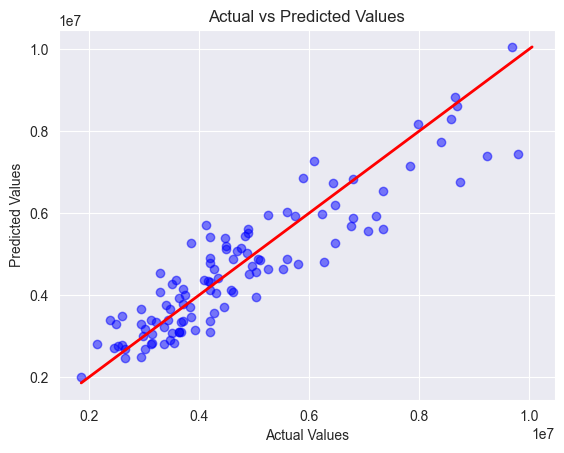

Mean Squared Error (MSE): 550988069262.7063
Root Mean Squared Error (RMSE): 742285.7060
Mean Absolute Error (MAE): 584670.4138
R-squared determination coefficient: 0.8259


In [24]:
# Write your code here

# HARD FEATURE SELECTION
# Let's select the most important features using the SelectKBest
features_to_select = len(independent_vars)//2
selector = SelectKBest(score_func=f_regression, k=features_to_select)  # Select same number as the original independent vars
X_train_half_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_half_selected = selector.transform(X_test_scaled)
# evaluate the model
print(f"Model performance after adding the polynomial features and selecting the best {features_to_select} features:")
utils.show_regression_performance(
    *utils.create_SDG_regression_model_and_evaluate(X_train_half_selected, y_train, X_test_half_selected, y_test, random_state))

# Exactly, the model's performance decreases because we are removing relevant features, making the model too simple (underfitting).

## ✨ Questions ✨

6. How do you think we could find the optimal number of features to select?

### Answers

*Write your answers here.*

6. Using a validation set, we could try different values, estimate the best one and perform the final evaluation of the model's performance using the test set.

## L1 (Lasso) Regularization

Let's apply L1 regularization to polynomial features with all the features (we will use the `SGDRegressor` model with L1 regularization). We first select too many features on purpose to see the effect of L1 regularization.